---
## Import các thư viện cần thiết

In [1]:
#Them tap validation
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import re

sb.set_style('whitegrid') # plot style

In [2]:
import xgboost as xgb
import sklearn
print('sklearn version: %s' % sklearn.__version__)
print('xgboost version: %s' % xgb.__version__)

sklearn version: 0.23.1
xgboost version: 1.3.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric




---
## Đọc dữ liệu từ file csv

In [4]:
#Website sofifa.com
df=pd.read_csv("./final_data.csv")
df.set_index('ID', inplace=True)
df=df.drop(['Unnamed: 0'], axis=1)
df = df.sample(frac=1)
df.head()

,Name,Position,Overall,Potential,BS,IR,PAC,SHO,PAS,DRI,DEF,PHY,Value,Wage,TotalStats
ID,,,,,,,,,,,,,,,
188572,G. Assulin,LW,64,64,325,1 ★,76,55,55,72,27,40,€575K,€3K,1525
254333,A. Hasić,CAM RM,65,81,346,1 ★,72,60,63,71,38,42,€1.8M,€5K,1653
257111,J. Le Douaron,RM ST,63,73,345,1 ★,74,54,56,58,29,74,€1.1M,€4K,1532
237662,B. Lennon,RM RB,68,73,395,1 ★,73,61,67,65,61,68,€1.9M,€3K,1849
110381,M. Rodríguez,LW LM ST,74,74,400,3 ★,66,75,75,75,44,65,€1.4M,€11K,1931


In [5]:
df.describe()

,Overall,Potential,BS,PAC,SHO,PAS,DRI,DEF,PHY,TotalStats
count,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000
mean,65.766029,71.076927,356.274641,67.536576,53.554226,57.808506,62.971823,49.957150,64.446358,1597.780595
std,6.937012,6.108600,40.539735,10.577109,13.792160,10.002520,9.834867,16.424582,9.533046,270.544005
min,47.000000,48.000000,232.000000,28.000000,17.000000,25.000000,25.000000,12.000000,28.000000,749.000000
25%,61.000000,67.000000,328.000000,62.000000,44.000000,51.000000,57.000000,35.000000,58.000000,1455.000000
50%,66.000000,71.000000,357.000000,68.000000,56.000000,58.000000,64.000000,53.000000,65.000000,1630.000000
75%,70.000000,75.000000,384.000000,75.000000,64.000000,65.000000,69.000000,63.000000,71.000000,1783.000000
max,93.000000,95.000000,501.000000,96.000000,93.000000,93.000000,95.000000,91.000000,91.000000,2325.000000


In [6]:
df.info() # => Không có dữ liệu rỗng

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18810 entries, 188572 to 232284
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        18810 non-null  object
 1   Position    18810 non-null  object
 2   Overall     18810 non-null  int64 
 3   Potential   18810 non-null  int64 
 4   BS          18810 non-null  int64 
 5   IR          18810 non-null  object
 6   PAC         18810 non-null  int64 
 7   SHO         18810 non-null  int64 
 8   PAS         18810 non-null  int64 
 9   DRI         18810 non-null  int64 
 10  DEF         18810 non-null  int64 
 11  PHY         18810 non-null  int64 
 12  Value       18810 non-null  object
 13  Wage        18810 non-null  object
 14  TotalStats  18810 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 2.3+ MB


---
## Giải thích các trường dữ liệu
 - NumAttack: Tổng số vị trí liên quan đến tấn công, gồm: LS, ST, RS, LW,LF,CF,RF,RW
 - NumMed: Tổng số vị trí nằm ở phần giữa sân, gồm: LAM, CAM, RAM, LM, LCM, CM,RCM, RM 
 - NumDeffend: Tổng số vị trí liên quan đến phòng thủ, gồm: LWB, LDM,CDM, RDM,RWB, LB, LCB, CB, RCB, RB
 - NumGK: Tổng số vị trí cho thủ môn, giá trị thuộc {0,1}
 - Overall: Chỉ số chung toàn cục của cầu thủ
 - Potential: Chỉ số chung tiềm  năng của cầu thủ
 - MedianMainStats: Trung vị của 6 chỉ số chung của thẻ cầu thủ
 - BS: Basic stats: Tổng số chỉ số của 6 chỉ số chung của thẻ cầu thủ.
 - IR: International reputation: Uy tín của cầu thủ, có giá trị thuộc {1, 2, 3, 4, 5}

---
## Làm sạch dữ liệu

Các cầu thủ có ID trùng đã được loại tại bước crawl data

## Data Transform

In [7]:
#Chuyển Value từ dạng string sang dạng số (triệu euro)
explo_data = df.copy()
# Value có hai loại giá trị là K và M, ta chuyển dạng mày thành dạng float triệu đô
explo_data["Value"] = explo_data["Value"].apply(lambda x: ('K' in x or 'k' in x)*float(re.findall('([0-9.]+)',x)[0])*0.001+
                ('M' in x or 'm' in x)*float(re.findall('([0-9.]+)',x)[0]))

### Define functions
- Khai báo các funtions cầ thiết cho việc chuyển đổi dữ liệu

In [8]:
# Khởi tạo list features được chọn
features_name = []

In [9]:
def TransFormData(X): 
    X=X.copy()
    X=getNummberIR(X)
    X=getNumPositions(X)
    X=getMedianMainStats(X)
    return X[['NumAttack', 'NumMed', 'NumDeffend','NumGK', 'Overall','Potential','MedianMainStats','BS','IR','TotalStats','Value']]
def getNumPositions(X): #Đếm số lượng vị trí chơi tốt của mỗi cầu thủ
    X['NumAttack']=X['Position'].apply(lambda x: 
                                       np.sum([y in ['LS', 'ST', 'RS', 'LW','LF','CF','RF','RW'] 
                                              for y in re.findall('([a-zA-z ]+)',x)[0].split()]))
    X['NumMed']=X['Position'].apply(lambda x: 
                                       np.sum([y in ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM','RCM', 'RM'] 
                                              for y in re.findall('([a-zA-z ]+)',x)[0].split()]))
    X['NumDeffend']=X['Position'].apply(lambda x:
                                       np.sum([y in ['LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'] 
                                              for y in re.findall('([a-zA-z ]+)',x)[0].split()]))
    X['NumGK']=X['Position'].apply(lambda x:
                                       np.sum([y in ['GK'] 
                                              for y in re.findall('([a-zA-z ]+)',x)[0].split()]))
    return X

def getNummberIR(X): # Chuyển IR từ dạng string sang số bằng việc loại kí tự "*" ở đuôi
    X['IR'] = X['IR'].apply(lambda x: float(x[0:len(x) - 1]))
    return X
def getMedianMainStats(X): # Lấy trung vị của 6 thuộc tính
    X['MedianMainStats']=X[['PAC','SHO','PAS','DRI','DEF','PHY']].apply(lambda row: np.median(row),axis=1)
    return X

def getAllFeature(X): # lấy tất cả các feature cần thiết
    X=X.copy()
    return X[features_name]

- Chuyển tất cả các dữ liệu string sang dạng numberic bằng các function khai báo trên

In [10]:
explo_data = TransFormData(explo_data)

- Loại các dòng có value  = 0
Chuyển cột value từ dạng string sang dang số (triệu Euro)
Xóa những cầu thủ có value = 0 vì:
 1. những cầu thủ này đã giải nghệ, trong thực tế không có giá trị gì cả 
 và trong game không tồn tại cầu thủ này
 2. Để việc tính RMSE trên tập test chính xác hơn. 

In [11]:
select_row = explo_data['Value'] != 0 
explo_data = explo_data[select_row]

- Khai báo FeatureExtracter cho pipeline

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureExtracter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return getAllFeature(X)

# Khám phá dữ liệu

In [13]:
explo_data['Value'].describe()

count    18810.000000
mean         2.910305
std          7.714588
min          0.009000
25%          0.475000
50%          1.000000
75%          2.100000
max        185.500000
Name: Value, dtype: float64

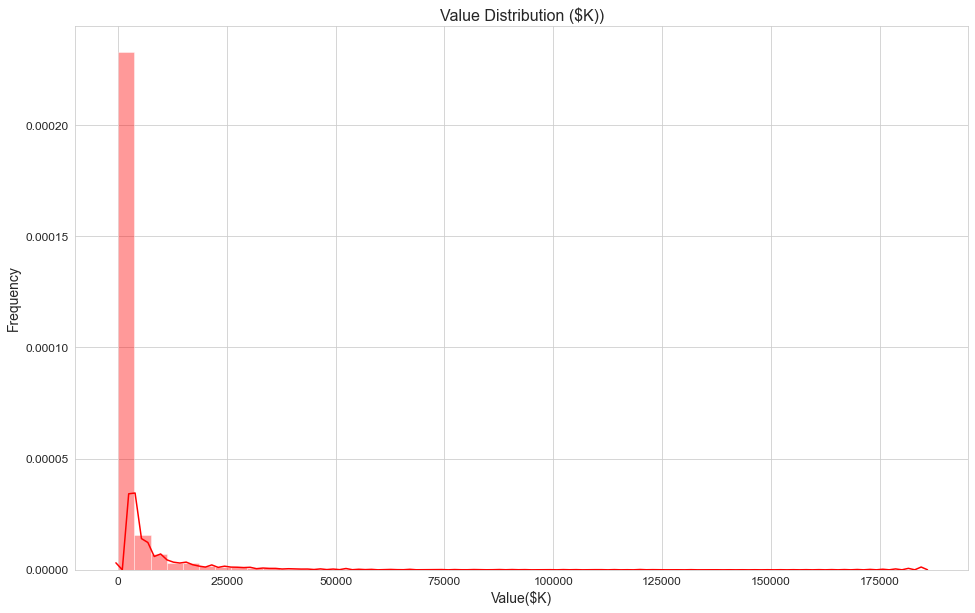

In [14]:

a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sb.distplot(explo_data['Value']*1000,ax=ax, color = 'r')
plt.title('Value Distribution ($K))', fontsize = 16)
plt.xlabel('Value($K)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('distplot.png')

plt.show()

In [15]:
explo_data['Value'].describe()

count    18810.000000
mean         2.910305
std          7.714588
min          0.009000
25%          0.475000
50%          1.000000
75%          2.100000
max        185.500000
Name: Value, dtype: float64

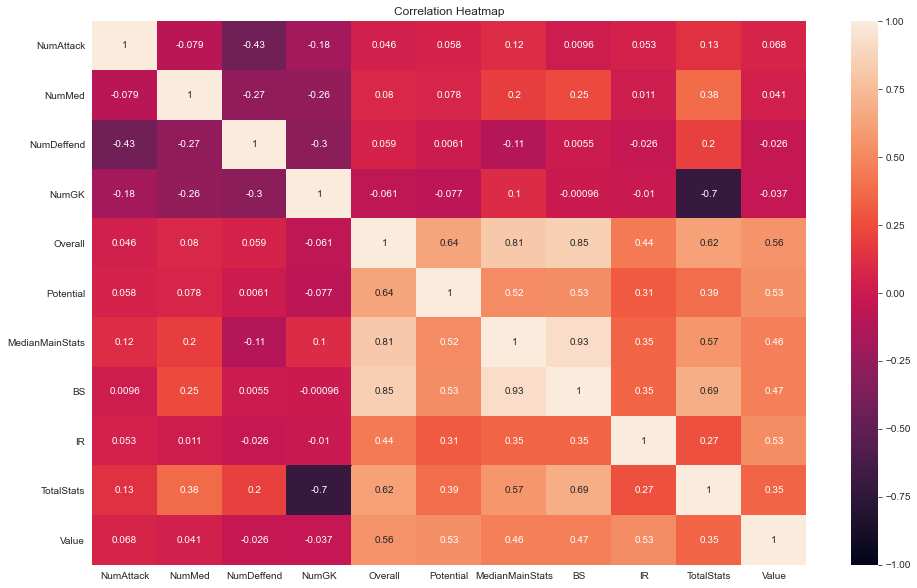

In [16]:
plt.figure(figsize=(16,10))

#mask = np.triu(np.ones_like(explo_data.corr(), dtype=np.bool))
#heatmap = sb.heatmap(explo_data.corr(),mask=mask, vmin=-1,vmax=1,annot=True)

heatmap = sb.heatmap(explo_data.corr(), vmin=-1,vmax=1,annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})
plt.savefig('maskheatmap.png', dpi=300, bbox_inches='tight')

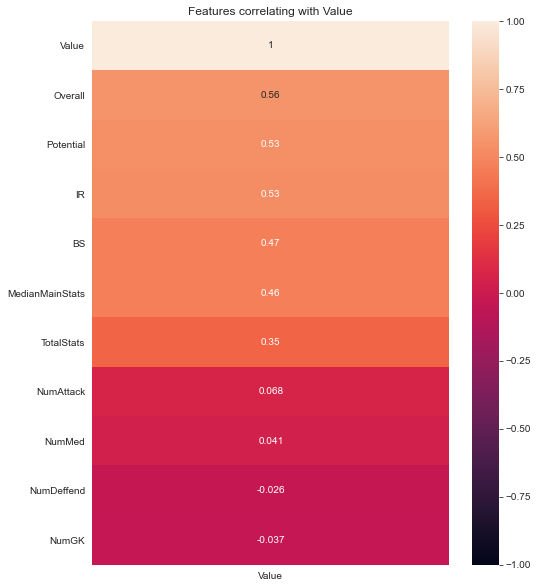

In [17]:
plt.figure(figsize=(8,10))
heatmap = sb.heatmap(explo_data.corr()[['Value']].sort_values(by='Value',ascending=False), vmin=-1,vmax=1,annot=True)
heatmap.set_title('Features correlating with Value', fontdict={'fontsize':12})
plt.savefig('featuresvsvalue.png', dpi=300, bbox_inches='tight')

### Visualize các features được chọn

- Features:  ['Overall', 'Potential', 'MedianMainStats', 'TotalStats', 'IR', 'BS'] > 0.3 correlation với Value của cầu thủ


In [18]:
features_name = explo_data.corr()[['Value']][explo_data.corr()[['Value']] > 0.3]
features_name = features_name.dropna().index
features_name = features_name.drop('Value')
features_name

Index(['Overall', 'Potential', 'MedianMainStats', 'BS', 'IR', 'TotalStats'], dtype='object')

In [19]:
features_name = ['Overall', 'Potential', 'MedianMainStats', 'BS', 'IR', 'TotalStats']

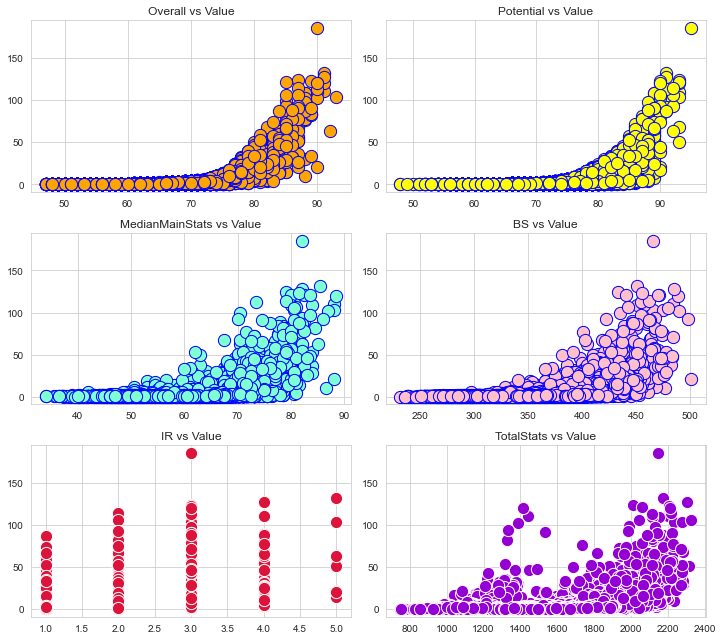

In [20]:
fig,ax = plt.subplots(3,2,figsize=(10,9))
sale_price = explo_data['Value'].values


ax[0,0].scatter(explo_data['Overall'],sale_price,color = 'orange', edgecolor = 'b', s =150)
ax[0,0].set_title('Overall vs Value')
ax[0,1].scatter(explo_data['Potential'],sale_price, color = 'yellow', edgecolor = 'b', s = 150)
ax[0,1].set_title('Potential vs Value')
ax[1,0].scatter(explo_data['MedianMainStats'],sale_price,color = 'aquamarine', edgecolor = 'b', s = 150)
ax[1,0].set_title('MedianMainStats vs Value')
ax[1,1].scatter(explo_data['BS'],sale_price,color = 'pink', edgecolor = 'b', s = 150)
ax[1,1].set_title('BS vs Value')
ax[2,0].scatter(explo_data['IR'],sale_price,color = 'crimson', edgecolor = 'white', s = 150)
ax[2,0].set_title('IR vs Value')
ax[2,1].scatter(explo_data['TotalStats'],sale_price, color = 'darkviolet', edgecolor = 'white', s = 150)
ax[2,1].set_title('TotalStats vs Value')
plt.tight_layout()

- Lọc những dữ liệu. 
- Lọc các dữ liệu phân bố rải rác ( giá trị cầu thủ quá lớn và tần xuất xuất hiện nhỏ)
- Giúp cải thiện model

In [21]:
totalrows = len(df)
selected_data = (explo_data['Value']*1000 <= 29000)
selectedrows = len(explo_data[selected_data])
print("Số % selected data chiếm= " , (selectedrows*100/totalrows) )
explo_data = explo_data[selected_data]

Số % selected data chiếm=  98.4635832004253


- train-test 80-20 split

In [22]:
# Tách tập train và tập test theo tỉ lệ 80%:20%
train_X_df, test_X_df, train_y_sr, test_y_sr = train_test_split(explo_data[features_name],explo_data['Value'], test_size=0.2, random_state=1000)

# Khởi tạo LogisticRegression 

In [23]:
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import utils

- Vì train_y_sr có dạng continuous nhưng LogisticRegression cần dữ liệu dạng multiclass. => Chuẩn hóa dữ liệu.
1. Chuyển Value từ dạng M euro sang euro. 
2. Ép kiểu int cho dạng dữ liệu float.

In [24]:
#Chuyển tập test_ỷ,train_y_sr từ dạng continous sang multiclass
train_y_convert = train_y_sr*1000000
train_y_convert = train_y_convert.astype(int)
train_y_convert = train_y_convert.values
test_y_convert = test_y_sr*1000000
test_y_convert = test_y_convert.astype(int)
test_y_convert = test_y_convert.values
print(utils.multiclass.type_of_target(train_y_sr))
print(utils.multiclass.type_of_target(train_y_sr.astype('int')))

continuous
multiclass


- Sử dụng pipeline + LogisticRegression giảm thời gian => train data

In [25]:
pipe_lg = Pipeline([("feature_extracter", FeatureExtracter()),
                               ("std_scaler", StandardScaler()),
                               ('linear_model',LogisticRegression(multi_class="multinomial", solver="lbfgs",max_iter=1000))])

In [26]:
pipe_lg.fit(train_X_df,train_y_convert)

Pipeline(steps=[('feature_extracter',
                 <__main__.FeatureExtracter object at 0x0000018D4F5D4730>),
                ('std_scaler', StandardScaler()),
                ('linear_model',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [27]:
lrpreds = pipe_lg.predict(test_X_df)
#Chuyển euro sang m euro
lrpreds = lrpreds/1000000.0
print("RMSE in test=", np.sqrt(mean_squared_error(lrpreds,test_y_sr)))
print("r2 in test=", r2(test_y_sr, lrpreds))

RMSE in test= 1.9874324863977653
r2 in test= 0.7387709416684256


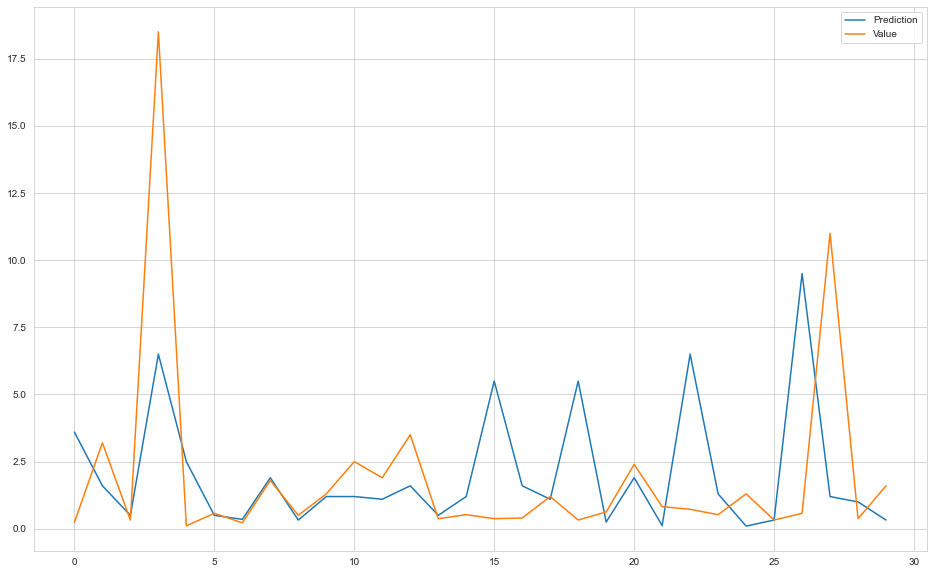

In [29]:
plt.figure(figsize=(16,10))
plt.plot(lrpreds[0:30], label="Prediction")
plt.plot(train_y_sr[0:30].values, label="Value")
plt.legend()
plt.show()

# Sử dụng Pipeline + XGBoost

## Mô hình XGBoost mặc định

In [30]:
pipe2 = Pipeline([("feature_extracter", FeatureExtracter()),
                               ("std_scaler", StandardScaler()),
                               ('xgboost',xgb.XGBRegressor())])
pipe2.fit(train_X_df,train_y_sr)
preds2=pipe2.predict(test_X_df)
RMSE2= np.sqrt(mean_squared_error(preds2,test_y_sr))
print("RMSE in test=", RMSE2)
print('Coefficient of determinatio regression score: %f' % r2(test_y_sr, preds2))

RMSE in test= 0.8486646330828004
Coefficient of determinatio regression score: 0.952367


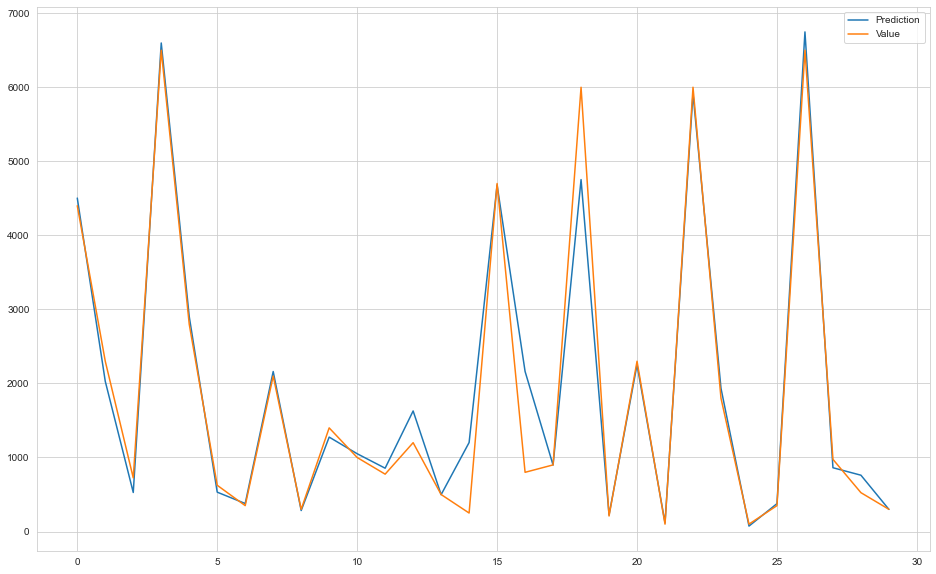

In [31]:
plt.figure(figsize=(16,10))
plt.plot(preds2[:30]*1000, label="Prediction")
plt.plot(test_y_sr.values[:30]*1000, label="Value")
plt.legend()
plt.show()

---
## Sử dụng kỹ thuật Grid Search và K-fold Cross-validation để chọn tham số
Lý do chọn k-fold cross validation
 - Do dữ liệu để học chỉ có vài nghìn row là quá ít cho việc training nên nếu chia quá nhiều cho tập validation thì tập train có quá ít dữ liệu để học và dẫn đến overfitting, do đó tập train phải càng lớn càng tốt, tức là tập validation phải nhỏ. Nhưng điều này lại có thể dẫn đến overfitting với tập training còn lại.

---
## Giải thích các siêu tham số cho tree boosting.
- n_estimators(mặc định 100): Số lượng  boosted trees để fit.
- learning_rate(mặc định 0.1, range=[0,1]): boosting step.
- gamma(mặc định 0, range=[0,${\infty}$]): Minimum loss reduction khi tạo 1 node mới. Gamma cao, regularization cao.
- max_depth(mặc định 6, range=[0,${\infty}$]): Chiều sâu tối đa của cây, max_depth càng cao thì mô hình càng phức tạp.
- min_child_weight(mặc định 1, range=[0,${\infty}$]): Tổng instance weight (hessian) tối thiểu trong 1 node con. min_child_weight chặn các potential feature tương tác với nhau để ngăn overfitting.
- subsample(mặc định 1, range=(0,1)): Phần trăm mẫu quan sát được cho mỗi cây.
- colsample_bytree(mặc định 1, range=(0,1)): Phần trăm features được lấy cho mỗi cây.
- reg_alpha(mặc định: 0): L1 regularization.

---
## Training

### Khởi tạo các siêu tham số

In [32]:
reg_alpha=0
min_child_weight=1
max_depth=6
learning_rate=0.1 
colsample_bytree=0.8
subsample=0.8
gamma=0
n_estimators=100

In [33]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search

### Khởi tạo pipeline

In [34]:
pipe = Pipeline([("feature_extracter", FeatureExtracter()),
                               ("std_scaler", StandardScaler()),
                               ('xgboost',xgb.XGBRegressor())])

### Bước 1: chọn early_stopping_rounds

#### Chọn k = 5, random_state = 2504 cho cross validation

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2504)

### Bước 1: chọn n_estimators

In [36]:
param_test0 = {
              'xgboost__nthread':[4], 
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [learning_rate], #so called `eta` value
              'xgboost__max_depth': [max_depth],
              'xgboost__min_child_weight': [min_child_weight], 
               'xgboost__gamma':[gamma],
              'xgboost__subsample': [subsample],
              'xgboost__colsample_bytree': [colsample_bytree],
              'xgboost__n_estimators': [25,50,75,100,125,150,175,200,250,300,350]}
# param_grid ={
#     'xgboost': param_test0
# }


kfold = KFold(n_splits=5, shuffle=True, random_state=2504)
gsearch0 = GridSearchCV(estimator = pipe, param_grid=param_test0,scoring='neg_mean_squared_error',n_jobs=4, cv=kfold)

gsearch0.fit(train_X_df,train_y_sr)

GridSearchCV(cv=KFold(n_splits=5, random_state=2504, shuffle=True),
             estimator=Pipeline(steps=[('feature_extracter',
                                        <__main__.FeatureExtracter object at 0x0000018D511514F0>),
                                       ('std_scaler', StandardScaler()),
                                       ('xgboost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importan...
             n_jobs=4,
             param_grid={'xgboost__colsample_bytree': [0.8],
                         'xgboost__gamma': [0], 'xgboos

In [37]:
# in ra kết quả
gsearch0.best_params_, gsearch0.best_score_

({'xgboost__colsample_bytree': 0.8,
  'xgboost__gamma': 0,
  'xgboost__learning_rate': 0.1,
  'xgboost__max_depth': 6,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__subsample': 0.8},
 -0.6913392984477225)

In [38]:
# lưu kết quả vào các biến n_estimators
n_estimators=gsearch0.best_params_['xgboost__n_estimators']
print("Chon n_estimators=%d"% n_estimators)

Chon n_estimators=100


### Bước 3: Chọn max_depth, min_child_weight

In [39]:
param_test1 = {'xgboost__nthread':[4],
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [learning_rate], #so called `eta` value
              'xgboost__max_depth': range(3,10,2),
              'xgboost__min_child_weight': range(1,6,2), 
               'xgboost__gamma':[gamma],
              'xgboost__subsample': [subsample],
              'xgboost__colsample_bytree': [colsample_bytree],
              'xgboost__n_estimators': [n_estimators]}

gsearch1 = GridSearchCV(estimator = pipe, scoring='neg_mean_squared_error',param_grid = param_test1,n_jobs=4, cv=kfold)
gsearch1.fit(train_X_df,train_y_sr)


GridSearchCV(cv=KFold(n_splits=5, random_state=2504, shuffle=True),
             estimator=Pipeline(steps=[('feature_extracter',
                                        <__main__.FeatureExtracter object at 0x0000018D511514F0>),
                                       ('std_scaler', StandardScaler()),
                                       ('xgboost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importan...
                                                     verbosity=None))]),
             n_jobs=4,
             param_grid={'xgboost__colsampl

In [40]:
# In ra kết quả
gsearch1.best_params_, gsearch1.best_score_

({'xgboost__colsample_bytree': 0.8,
  'xgboost__gamma': 0,
  'xgboost__learning_rate': 0.1,
  'xgboost__max_depth': 5,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__subsample': 0.8},
 -0.6830860782802359)

In [41]:
# Lưu kết quả vào các biến max_depth min_child_weight
max_depth=gsearch1.best_params_['xgboost__max_depth']
min_child_weight=gsearch1.best_params_['xgboost__min_child_weight']
print("Chon max_depth=%d, chon min_child_weight=%d"% (max_depth,min_child_weight))

Chon max_depth=5, chon min_child_weight=1


### Bước 4: Chọn gamma để chống overfitting

In [42]:
param_test2 = {'xgboost__nthread':[4], 
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [learning_rate], #so called `eta` value
              'xgboost__max_depth': [max_depth],
              'xgboost__min_child_weight': [min_child_weight],
               'xgboost__gamma':[i/10.0 for i in range(0,5)],
              'xgboost__subsample': [subsample],
              'xgboost__colsample_bytree': [colsample_bytree],
              'xgboost__n_estimators': [n_estimators]}

gsearch2 = GridSearchCV(estimator = pipe, scoring='neg_mean_squared_error',param_grid = param_test2,n_jobs=4, cv=kfold)
gsearch2.fit(train_X_df,train_y_sr)
gsearch2.best_params_, gsearch2.best_score_

({'xgboost__colsample_bytree': 0.8,
  'xgboost__gamma': 0.1,
  'xgboost__learning_rate': 0.1,
  'xgboost__max_depth': 5,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__subsample': 0.8},
 -0.6803087453071336)

In [43]:
# Lưu lại gamma
gamma=gsearch2.best_params_['xgboost__gamma']
print("Chon gamma=%f"%gamma)

Chon gamma=0.100000


### Bước 5: Chọn subsample và colsample_bytree

In [44]:
param_test4 = {
            'xgboost__nthread':[4], 
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [learning_rate], #so called `eta` value
              'xgboost__max_depth': [max_depth],
              'xgboost__min_child_weight': [min_child_weight],
              'xgboost__gamma':[gamma],
              'xgboost__subsample':[i/10.0 for i in range(3,10)],
              'xgboost__colsample_bytree':[i/10.0 for i in range(3,10)],
              'xgboost__n_estimators': [n_estimators]
}
gsearch4 = GridSearchCV(estimator = pipe, scoring='neg_mean_squared_error',param_grid = param_test4,n_jobs=4, cv=kfold)
gsearch4.fit(train_X_df,train_y_sr)
gsearch4.best_params_, gsearch4.best_score_

({'xgboost__colsample_bytree': 0.9,
  'xgboost__gamma': 0.1,
  'xgboost__learning_rate': 0.1,
  'xgboost__max_depth': 5,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__subsample': 0.8},
 -0.6627099012463762)

In [45]:
# Lưu lại colsample_bytree, subsample
colsample_bytree=gsearch4.best_params_['xgboost__colsample_bytree']
subsample=gsearch4.best_params_['xgboost__subsample']
print("Chon subsample=%f, colsample_bytree=%f"%(subsample,colsample_bytree))

Chon subsample=0.800000, colsample_bytree=0.900000


### Bước 6: Chọn reg_alpha để chống overfitting

In [46]:
param_test5 = {
              'xgboost__nthread':[4], 
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [learning_rate], #so called `eta` value
              'xgboost__max_depth': [max_depth],
              'xgboost__min_child_weight': [min_child_weight],
              'xgboost__gamma':[gamma],
              'xgboost__subsample':[subsample],
              'xgboost__colsample_bytree':[colsample_bytree],
              'xgboost__n_estimators': [n_estimators],
             'xgboost__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]

}
gsearch5 = GridSearchCV(estimator = pipe, scoring='neg_mean_squared_error',param_grid = param_test5,n_jobs=4, cv=kfold)
gsearch5.fit(train_X_df,train_y_sr)
gsearch5.best_params_, gsearch5.best_score_

({'xgboost__colsample_bytree': 0.9,
  'xgboost__gamma': 0.1,
  'xgboost__learning_rate': 0.1,
  'xgboost__max_depth': 5,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__reg_alpha': 1,
  'xgboost__subsample': 0.8},
 -0.6424907890253525)

In [47]:
# Lưu lại reg_alpha
reg_alpha=gsearch5.best_params_['xgboost__reg_alpha']
print("Chon reg_alpha=%f"%reg_alpha)

Chon reg_alpha=1.000000


### Bước 7: Chọn learning_rate

In [48]:
param_test6 = {
              'xgboost__nthread':[4], 
              'xgboost__objective':['reg:squarederror'],
              'xgboost__learning_rate': [0.01,0.03,0.06,0.09, 0.1,0.11,0.12,0.13,0.15], #so called `eta` value
              'xgboost__max_depth': [max_depth],
              'xgboost__min_child_weight': [min_child_weight],
              'xgboost__gamma':[gamma],
              'xgboost__subsample':[subsample],
              'xgboost__colsample_bytree':[colsample_bytree],
              'xgboost__n_estimators': [n_estimators],
             'xgboost__reg_alpha':[reg_alpha]

}
gsearch6 = GridSearchCV(estimator = pipe, scoring='neg_mean_squared_error',param_grid = param_test6,n_jobs=4, cv=5)
gsearch6.fit(train_X_df,train_y_sr)
gsearch6.best_params_, gsearch6.best_score_

({'xgboost__colsample_bytree': 0.9,
  'xgboost__gamma': 0.1,
  'xgboost__learning_rate': 0.06,
  'xgboost__max_depth': 5,
  'xgboost__min_child_weight': 1,
  'xgboost__n_estimators': 100,
  'xgboost__nthread': 4,
  'xgboost__objective': 'reg:squarederror',
  'xgboost__reg_alpha': 1,
  'xgboost__subsample': 0.8},
 -0.586236213830104)

In [49]:
learning_rate=gsearch6.best_params_['xgboost__learning_rate']
print("Chon learning_rate =",learning_rate)

Chon learning_rate = 0.06


In [50]:
print("Cac tham so lua chon la:")
print("reg_alpha:",reg_alpha)
print("min_child_weight:",min_child_weight)
print("learning_rate:",learning_rate)
print("subsample:",subsample)
print("colsample_bytree:",colsample_bytree)
print("max_depth:",max_depth)
print("gamma:",gamma)
print("n_estimators:",n_estimators)

Cac tham so lua chon la:
reg_alpha: 1
min_child_weight: 1
learning_rate: 0.06
subsample: 0.8
colsample_bytree: 0.9
max_depth: 5
gamma: 0.1
n_estimators: 100


---
## Tiến hành dự đoán trên tập test

In [51]:
pipe.set_params(**gsearch6.best_params_)

Pipeline(steps=[('feature_extracter',
                 <__main__.FeatureExtracter object at 0x0000018D511514F0>),
                ('std_scaler', StandardScaler()),
                ('xgboost',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.06,
                              max_delta_step=None, max_depth=5,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, nthread=4, num_parallel_tree=None,
                              random_state=None, reg_alpha=1, reg_lambda=None,
                              scale_pos_weight=None, subsample=0.8,
                              tre

In [52]:
pipe.fit(train_X_df,train_y_sr)

Pipeline(steps=[('feature_extracter',
                 <__main__.FeatureExtracter object at 0x0000018D511514F0>),
                ('std_scaler', StandardScaler()),
                ('xgboost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.06,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=4, nthread=4,
                              num_parallel_tree=1, random_state=0, reg_alpha=1,
                              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
                              tree_method='exact', validate_parameters=1,
              

In [53]:
preds=pipe.predict(test_X_df)

In [54]:
RMSE=np.sqrt(mean_squared_error(preds,test_y_sr))

In [55]:
print("RMSE in test = ",RMSE)
print('Coefficient of determinatio regression score: %f' % r2(test_y_sr, preds))

RMSE in test =  0.823317961877732
Coefficient of determinatio regression score: 0.955170


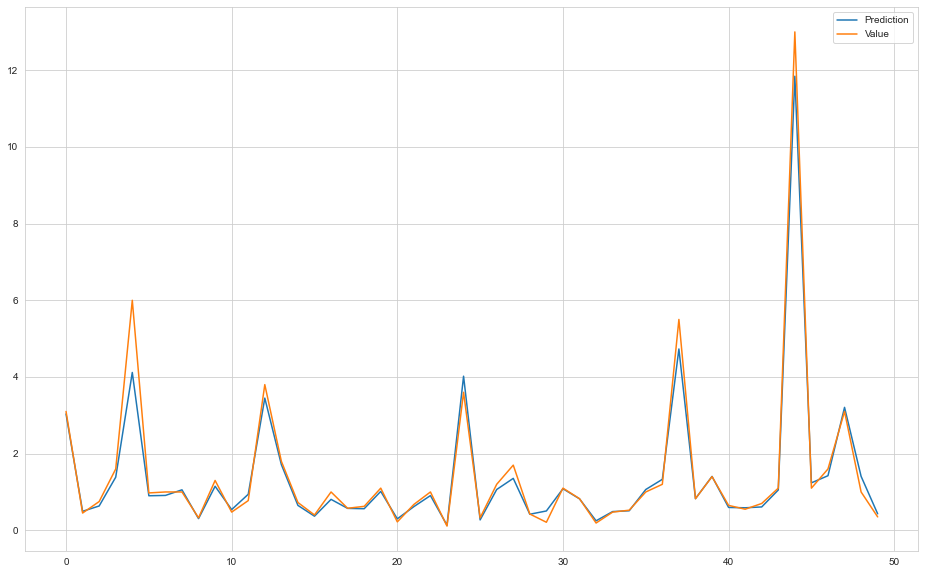

In [56]:
plt.figure(figsize=(16,10))
plt.plot(preds[40:90], label="Prediction")
plt.plot(test_y_sr[40:90].values, label="Value")
plt.legend()
plt.show()

# Kết luận
- XGBoost có độ chính xác cao hơn Softmax Regression rất nhiều (r2 | 0.954431 > 0.7332808713518575).
Chọn XGBoost đẻ dự đoán giá trị của cầu thủ sẽ tốt hơn.